5.1 Image compression

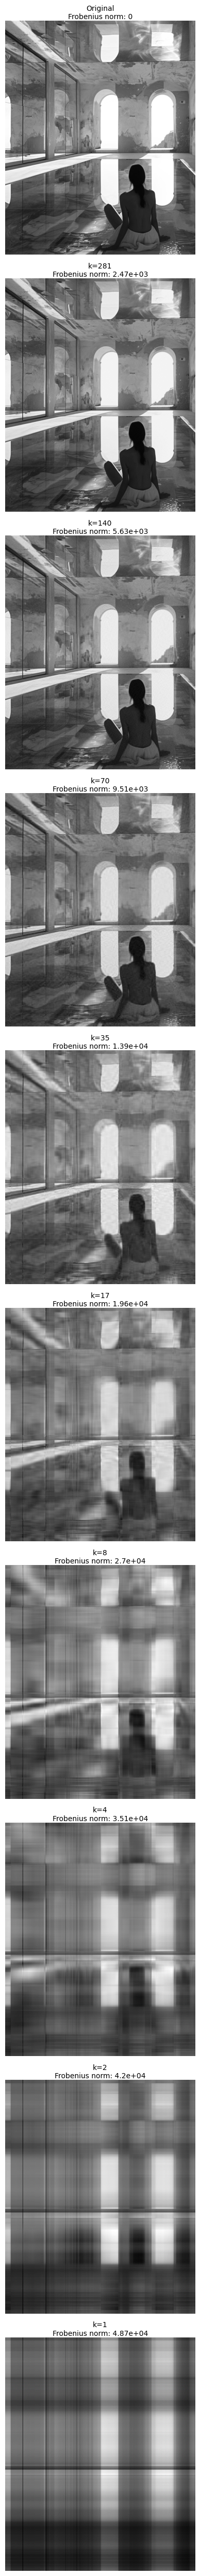

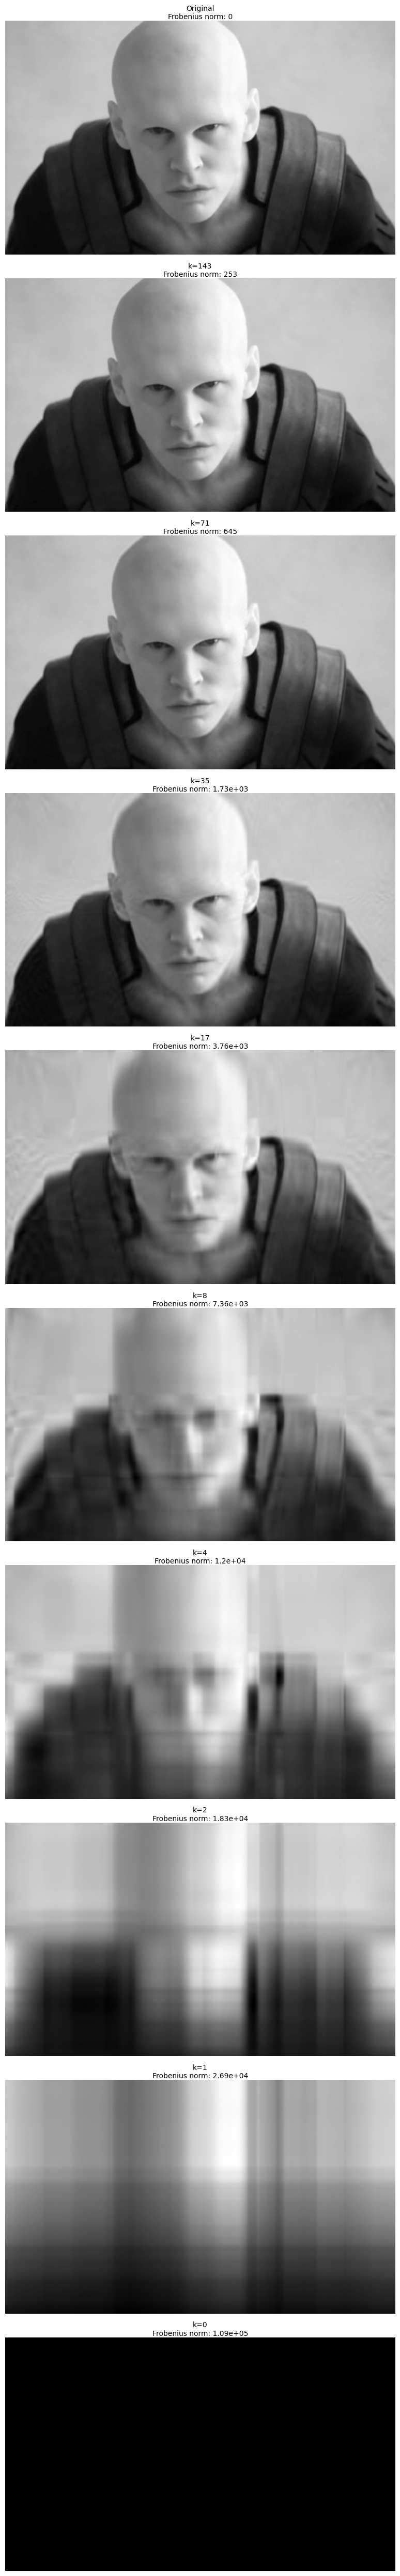

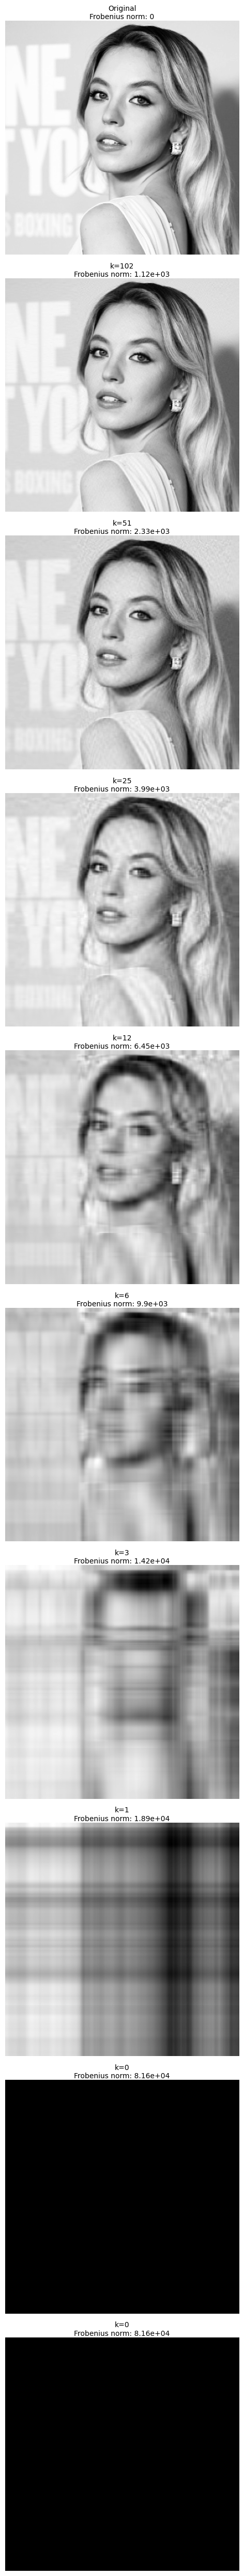

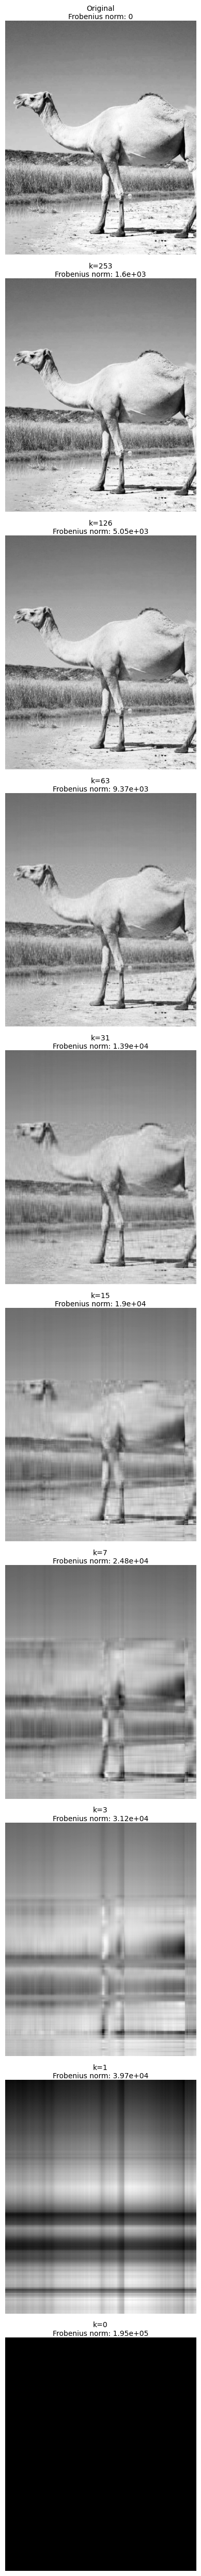

In [34]:
import numpy as np
import scipy
from PIL import Image
import matplotlib.pyplot as plt

def load_image(file_path):
    with Image.open(file_path) as img:
        return np.array(img.convert('L'))

def compute_svd(image_matrix):
    U, s, Vt = np.linalg.svd(image_matrix, full_matrices=False)
    return U, s, Vt

def compress_image(U, s, Vt, k):
    S = np.diag(s[:k])
    return np.dot(U[:, :k], np.dot(S, Vt[:k, :]))

def plot_images(images, titles, frobenius_norms, base_filename):
    rows = len(images)
    plt.figure(figsize=(20, 5 * rows))
    for i, (image, title, fro_norm) in enumerate(zip(images, titles, frobenius_norms)):
        plt.subplot(rows, 1, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'{title}\nFrobenius norm: {fro_norm:.3g}', fontsize=10, pad=3)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(base_filename)  # Save the figure to file
    plt.show()
    
def frobenius_norm(original, approx):
    return np.linalg.norm(original - approx)

# Path of the images to be processed
image_paths = ['ph121_image1.jpg', 'ph121_image2.jpg', 'ph121_image3.jpg', 'ph121_image4.jpg']

for path in image_paths:  
    A = load_image(path)
    U, s, Vt = compute_svd(A)
    ks = [len(s)//4, len(s)//8, len(s)//16, len(s)//32, len(s)//64, len(s)//128, len(s)//256, len(s)//512, len(s)//1024]
    images = [A]  # Store the original and compressed images
    titles = ['Original']  # Titles for the images
    frobenius_norms = [0]  # The original image has no Frobenius norm difference
    
    for k in ks:
        A_k = compress_image(U, s, Vt, k)
        images.append(A_k)
        fro_norm = frobenius_norm(A, A_k)
        frobenius_norms.append(fro_norm)
        titles.append(f'k={k}')
    
    # Create a unique filename for each figure
    filename = f'{path[:-4]}_compression_results.png'
    plot_images(images, titles, frobenius_norms, filename)


In [1]:
from scipy.sparse import csr_matrix
import scipy
from tqdm import tqdm
def ising_sparse(L,h,J,periodic):
  rows = []
  cols = []
  matrix_elements = []
  for b in range(2**L):
    for j in range(1, L + 1):
      a = b ^ (1 << (j - 1))
      rows.append(a)
      cols.append(b)
      matrix_elements.append(-h)

  for a in range(2**L):
    diagonal_value =0
    for j in range(1, L):
        if a & (1 << j) == (a & (1 << (j - 1))) * 2:
            diagonal_value -= J
        else:
            diagonal_value += J

    if periodic:
        if (a & (1 << (L - 1))) == ((a & 1) * (2 ** (L - 1))):
            diagonal_value -= 1
        else:
            diagonal_value += 1
    if diagonal_value != 0:       
        rows.append(a)
        cols.append(a)
        matrix_elements.append(diagonal_value)
  H_sparse = csr_matrix((matrix_elements, (rows, cols)), shape=(2**L, 2**L), dtype=np.float64)
  return H_sparse

solving at representative points in the ferromagnetic and paramagnetic
phases and at critical h

In [12]:
#ferromagnetic
ground_state = scipy.sparse.linalg.eigsh(ising_sparse(10,0.3,1,False), k=1, which='SA', return_eigenvectors=False)[0]
print(ground_state)

-9.27182470645144


In [11]:
#paramagnetic
ground_state = scipy.sparse.linalg.eigsh(ising_sparse(10,1.7,1,False), k=1, which='SA', return_eigenvectors=False)[0]
print(ground_state)

-18.347282784087582


In [10]:
#critical h=1
ground_state = scipy.sparse.linalg.eigsh(ising_sparse(10,1,1,False), k=1, which='SA', return_eigenvectors=False)[0]
print(ground_state)

-12.381489999654754


Calculating the entanglement entropy S(l;L) 

In [4]:
from qutip import Qobj, entropy_vn
import numpy as np



H=ising_sparse(12,0.4,1, False)
def entanglement_entropy(H, L, l):
    # Diagonalize the Hamiltonian to get the ground state
    eigvals, eigvecs = scipy.sparse.linalg.eigsh(H, k=1, which='SA')
    ground_state_vec = eigvecs
    
    # Convert the ground state vector to a QuTiP quantum object
    ground_state = Qobj(ground_state_vec, dims=[[2] * L, [1]])
    
    # Trace out the system except the first l sites
    subspace_dims = [2] * L  # Spin-1/2 system, so dimension is 2 for each site
    subsystem_A = list(range(l))  # Sites included in subsystem A
    rho_A = ground_state.ptrace(subsystem_A)
    
    # Diagonalize the reduced density matrix
    rho_A_eigenvalues = rho_A.eigenenergies()
    # Calculate the entanglement entropy
    entropy = -sum(eigenval * np.log(eigenval) for eigenval in rho_A_eigenvalues if eigenval>0)
    return entropy

# Now you would call this function with H_sparse, L, and l as arguments.


# Parameters
L = 12  # Total number of sites
l = 3   # Number of sites in subsystem A
periodic = False  # Set to True for periodic boundar*y conditions


# Compute entanglement entropy
S_l_L = entanglement_entropy(H, L, l)
print(f"Entanglement entropy S({l};{L}) = {S_l_L}")

Entanglement entropy S(3;12) = 0.6922642035144888


Plotting S(l,L) as a function of l for different values of L=[9,10,11,12,13,14]

For open boundary conditions

Calculating Entropy for L=14, h=0.4: 100%|██████| 13/13 [01:44<00:00,  8.07s/it]


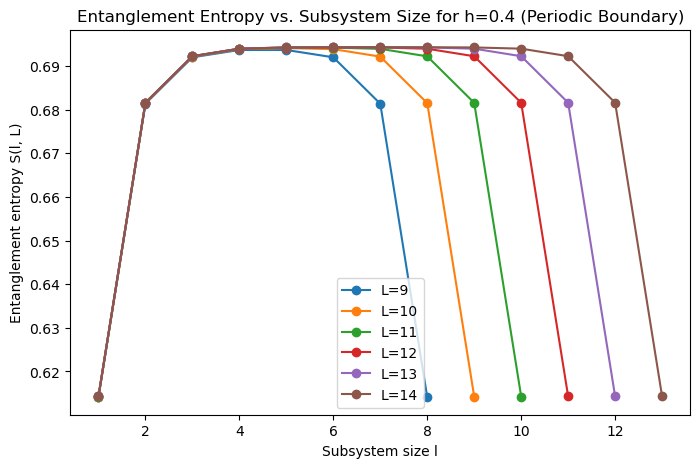

Calculating Entropy for L=14, h=1: 100%|████████| 13/13 [01:56<00:00,  8.99s/it]


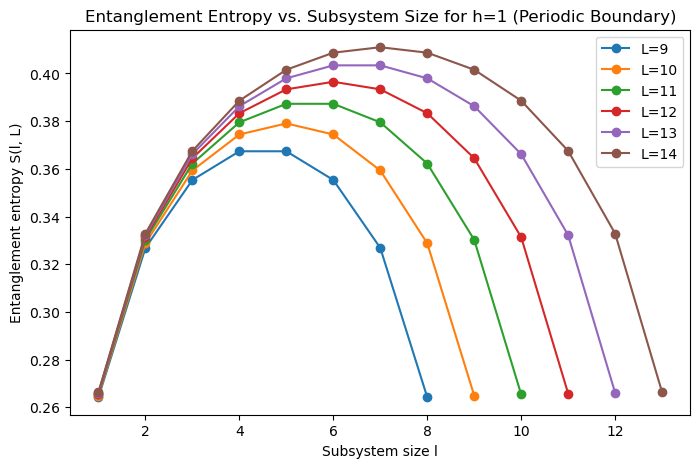

Calculating Entropy for L=14, h=1.7: 100%|██████| 13/13 [02:11<00:00, 10.10s/it]


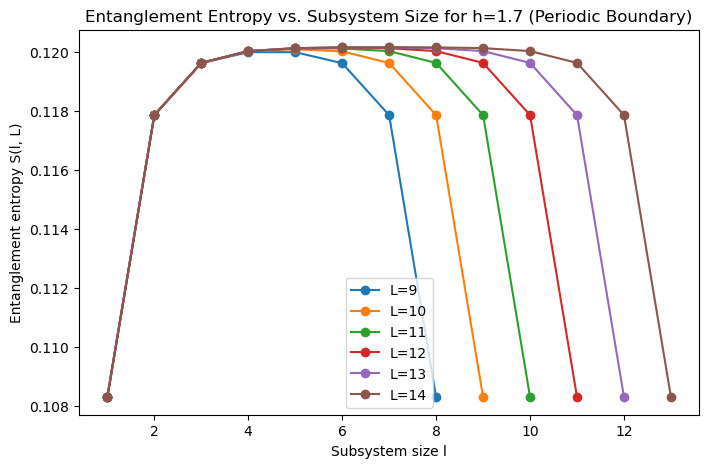

In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm


h_values = [0.4, 1, 1.7]
L_values = [9, 10, 11, 12, 13, 14]

# Loop over h values
for h in h_values:
    # Prepare the figure for the current h value
    plt.figure(figsize=(8, 5))

    # Loop over L values
    for L in L_values:
        periodic = True
        H = ising_sparse(L, h, 1, periodic=False)  # Create Hamiltonian with current h

        # Compute entanglement entropy for each l
        entropies = []
        ls = range(1, L)  # l values from 1 to L-1

        # Wrap ls with tqdm to show the progress bar
        for l in tqdm(ls, desc=f"Calculating Entropy for L={L}, h={h}"):
            entropy = entanglement_entropy(H, L, l)
            entropies.append(entropy)

        # Plot the entanglement entropy S(l, L) as a function of l
        plt.plot(ls, entropies, marker='o', label=f'L={L}')

    # Finalize the plot for the current h value
    plt.xlabel('Subsystem size l')
    plt.ylabel('Entanglement entropy S(l, L)')
    plt.title(f'Entanglement Entropy vs. Subsystem Size for h={h} (Periodic Boundary)')
    plt.legend()
    plt.show()
        


Plot of S(L/2,L)as a function of L

Calculating Entropy for h=1.7: 100%|████████████| 12/12 [00:00<00:00, 13.07it/s]


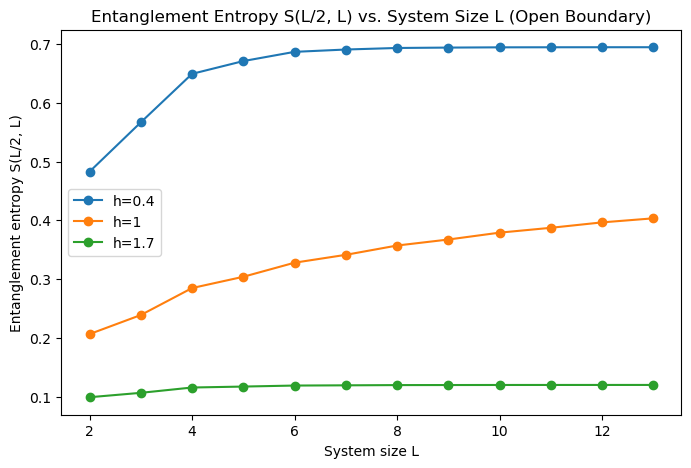

In [24]:
import matplotlib.pyplot as plt
from tqdm import tqdm


L_values = range(2, 14)
h_values = [0.4, 1, 1.7]

# Prepare the plot
plt.figure(figsize=(8, 5))

# Loop over h values
for h in h_values:
    entropy_values = []

    # Calculate entanglement entropy for L/2 for each L
    for L in tqdm(L_values, desc=f"Calculating Entropy for h={h}"):
        periodic = False
        H = ising_sparse(L, h, 1, periodic)
        
        # Compute entanglement entropy for the middle of the chain, L/2
        l = L // 2  # Use floor division to handle odd L
        entropy = entanglement_entropy(H, L, l)
        entropy_values.append(entropy)

    # Plot S(L/2, L) as a function of L for the current h
    plt.plot(list(L_values), entropy_values, marker='o', label=f'h={h}')

# Finalize the plot
plt.xlabel('System size L')
plt.ylabel('Entanglement entropy S(L/2, L)')
plt.title('Entanglement Entropy S(L/2, L) vs. System Size L (Open Boundary)')
plt.legend()
plt.show()

Now repeat with closed boundary conditions

Calculating Entropy for L=14, h=0.4: 100%|██████| 13/13 [01:25<00:00,  6.61s/it]


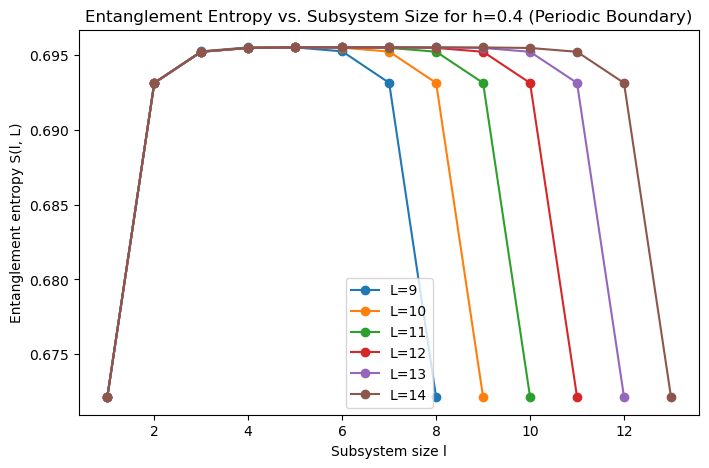

Calculating Entropy for L=14, h=1: 100%|████████| 13/13 [02:10<00:00, 10.05s/it]


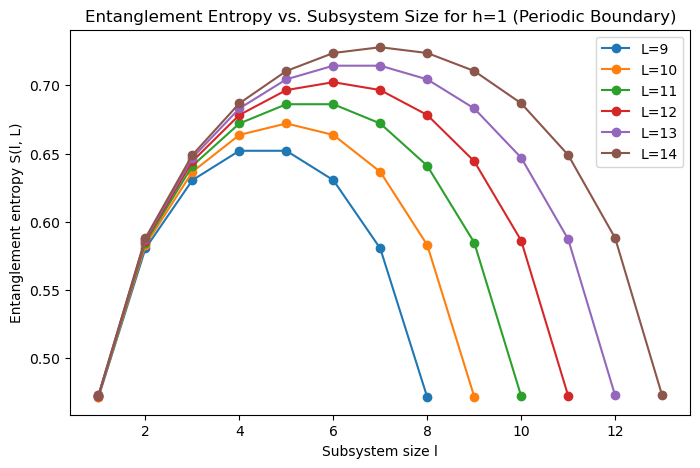

Calculating Entropy for L=14, h=1.7: 100%|██████| 13/13 [01:52<00:00,  8.69s/it]


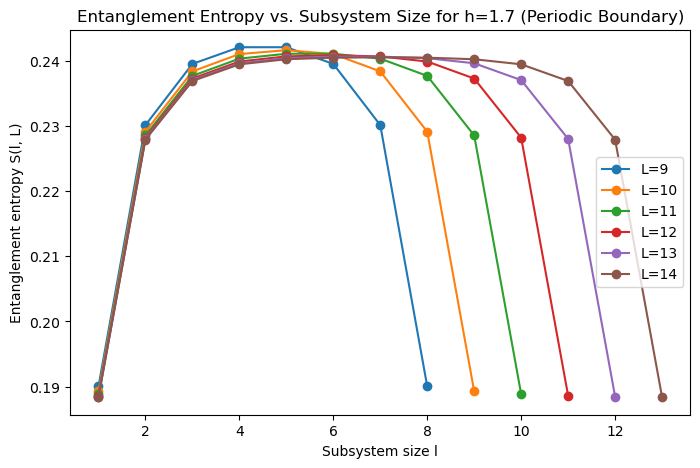

In [30]:
import matplotlib.pyplot as plt
from tqdm import tqdm


h_values = [0.4, 1, 1.7]
L_values = [9, 10, 11, 12, 13, 14]

# Loop over h values
for h in h_values:
    # Prepare the figure for the current h value
    plt.figure(figsize=(8, 5))

    # Loop over L values
    for L in L_values:
        periodic = True
        H = ising_sparse(L, h, 1, periodic)  # Create Hamiltonian with current h

        # Compute entanglement entropy for each l
        entropies = []
        ls = range(1, L)  # l values from 1 to L-1

        # Wrap ls with tqdm to show the progress bar
        for l in tqdm(ls, desc=f"Calculating Entropy for L={L}, h={h}"):
            entropy = entanglement_entropy(H, L, l)
            entropies.append(entropy)

        # Plot the entanglement entropy S(l, L) as a function of l
        plt.plot(ls, entropies, marker='o', label=f'L={L}')

    # Finalize the plot for the current h value
    plt.xlabel('Subsystem size l')
    plt.ylabel('Entanglement entropy S(l, L)')
    plt.title(f'Entanglement Entropy vs. Subsystem Size for h={h} (Periodic Boundary)')
    plt.legend()
    plt.show()


Calculating Entropy for h=1.7: 100%|████████████| 13/13 [00:01<00:00,  8.34it/s]


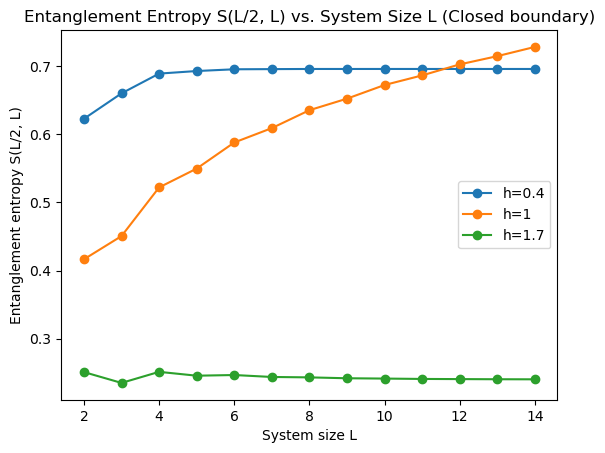

In [36]:
import matplotlib.pyplot as plt
from tqdm import tqdm


h_values = [0.4, 1, 1.7]  # The given magnetic field strengths
L_values = range(2, 15)   # The range of system sizes

# Loop over h values
for h in h_values:
    entropy_values = []

    # Calculate entanglement entropy for L/2 for each L
    for L in tqdm(L_values, desc=f"Calculating Entropy for h={h}"):
        periodic = True
        H = ising_sparse(L, h, 1, periodic)  # Create Hamiltonian with current h
        
        # Compute entanglement entropy for the middle of the chain, L/2
        l = L // 2  # Use floor division to handle odd L
        entropy = entanglement_entropy(H, L, l)
        entropy_values.append(entropy)

    # Plot S(L/2, L) as a function of L for the current h
    plt.plot(list(L_values), entropy_values, marker='o', label=f'h={h}')

# Finalize the plot
plt.xlabel('System size L')
plt.ylabel('Entanglement entropy S(L/2, L)')
plt.title('Entanglement Entropy S(L/2, L) vs. System Size L (Closed boundary)')
plt.legend()
plt.show()


Entaglement Entropy is much larger since a closed loop increases the number of paths along which quantum correlations can propagate. Closed systems lack edges, so there are no boundary spins that only interact with one neighbor, which would otherwise reduce the entanglement entropy.

Fit of entaglement entropy with function

Calculating Entropy: 100%|██████████████████████| 13/13 [01:48<00:00,  8.36s/it]

c: 0.2886991302558078, C: 0.268147473255902


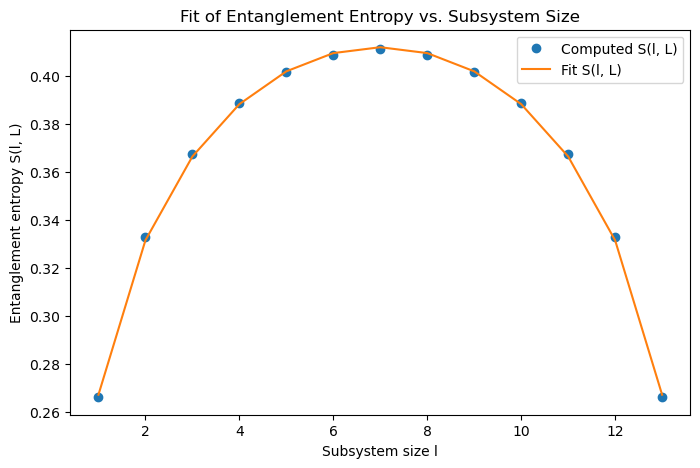

In [5]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
L=14
H=ising_sparse(L,1,1, False)
# Define the fit function
def fit_function(l, c, C):

    return (c / 3) * np.log((L / np.pi) * np.sin(np.pi * l / L)) + C
# Wrap ls with tqdm to show the progress bar
entropies = []
ls = range(1,L)
for l in tqdm(ls, desc="Calculating Entropy"):
    entropy = entanglement_entropy(H, L, l)
    entropies.append(entropy)


# Subsystem sizes l used to compute the entropies
ls = np.arange(1, L)  # Assuming you've computed entropies for these values of l

# Perform the curve fitting
popt, pcov = curve_fit(fit_function, ls, entropies)

# Extract the fit parameters
c_fit, C_fit = popt

# Print the fit parameters
print(f"c: {c_fit}, C: {C_fit}")

# Plot the original entropies and the fit
plt.figure(figsize=(8, 5))
plt.plot(ls, entropies, 'o', label='Computed S(l, L)')
plt.plot(ls, fit_function(ls, *popt), '-', label='Fit S(l, L)')
plt.xlabel('Subsystem size l')
plt.ylabel('Entanglement entropy S(l, L)')
plt.title('Fit of Entanglement Entropy vs. Subsystem Size')
plt.legend()
plt.show()


Similar for highest energy of the hamiltonian for open boundary conditions

In [ ]:
Function computing the entaglement entropy

In [10]:
from qutip import Qobj
import scipy.sparse.linalg
import numpy as np
L = 12  # Total number of sites
l = 3   # Number of sites in subsystem A
H=ising_sparse(L,1,1,False)
def entanglement_entropy(H, L, l, highest=False):
    # Choose the right eigenvalue to solve for
    which_eig = 'LA' if highest else 'SA'

    # Diagonalize the Hamiltonian to get the desired state
    eigvals, eigvecs = scipy.sparse.linalg.eigsh(H, k=1, which=which_eig)
    state_vec = eigvecs
    
    # Convert the state vector to a QuTiP quantum object
    state = Qobj(state_vec, dims=[[2] * L, [1]])
    
    # Trace out the system except the first l sites
    subspace_dims = [2] * L  # Spin-1/2 system, so dimension is 2 for each site
    subsystem_A = list(range(l))  # Sites included in subsystem A
    rho_A = state.ptrace(subsystem_A)
    
    # Calculate the entanglement entropy using QuTiP's built-in function
    entropy = entropy_vn(rho_A, base=np.e)
    
    return entropy

# Now you would call this function with H, L, l, and highest=True as arguments for the highest excited state.

# Parameters


# Compute entanglement entropy for the highest excited state
S_l_L_highest = entanglement_entropy(H, L, l, highest=True)
print(f"Entanglement entropy for the highest excited state S({l};{L}) = {S_l_L_highest}")


Entanglement entropy for the highest excited state S(3;12) = 0.3644464414919011


plot of entaglement entropy vs susbsystem size with highest excited state

Calculating Entropy for L=14, h=0.4: 100%|██████| 13/13 [01:49<00:00,  8.44s/it]


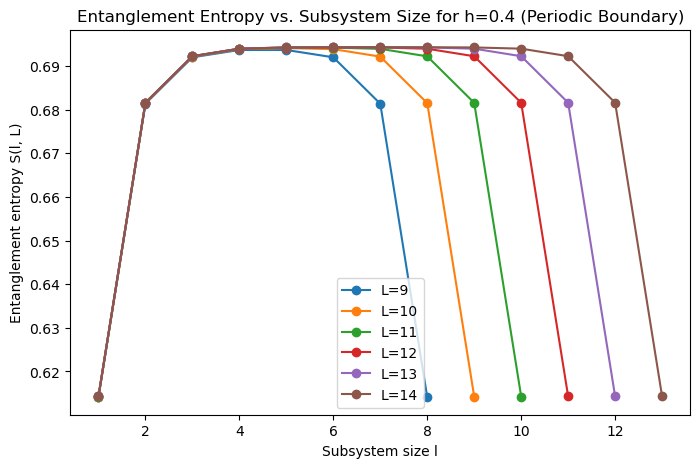

Calculating Entropy for L=14, h=1: 100%|████████| 13/13 [02:42<00:00, 12.53s/it]


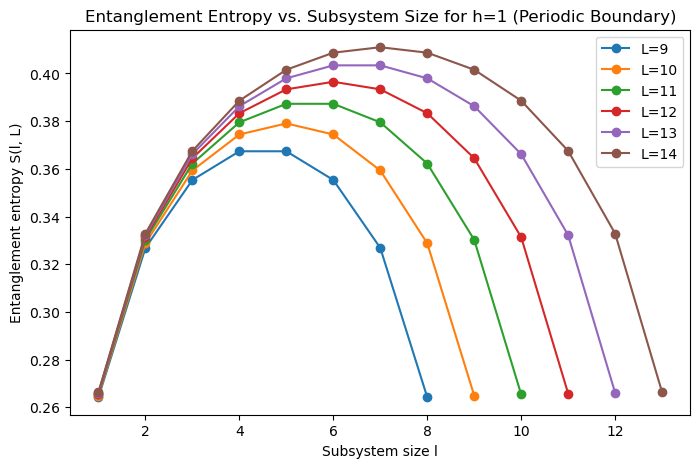

Calculating Entropy for L=14, h=1.7: 100%|██████| 13/13 [02:02<00:00,  9.42s/it]


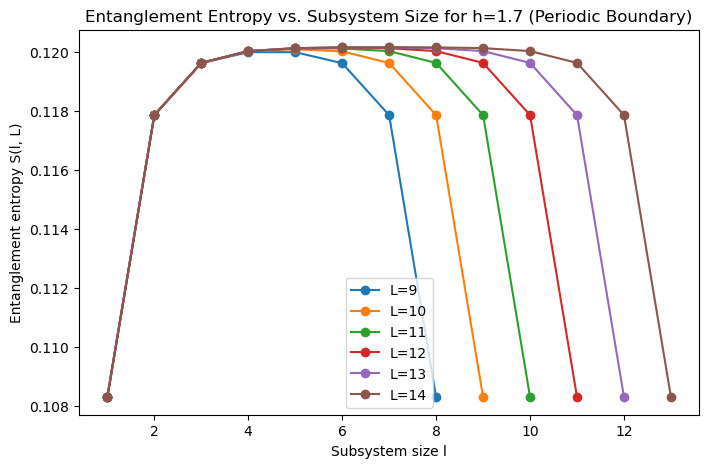

In [15]:
import matplotlib.pyplot as plt
from tqdm import tqdm


h_values = [0.4, 1, 1.7]
L_values = [9, 10, 11, 12, 13, 14]

# Loop over h values
for h in h_values:
    # Prepare the figure for the current h value
    plt.figure(figsize=(8, 5))

    # Loop over L values
    for L in L_values:
        periodic = True
        H = ising_sparse(L, h, 1, False)  # Create Hamiltonian with current h

        # Compute entanglement entropy for each l
        entropies = []
        ls = range(1, L)  # l values from 1 to L-1

        # Wrap ls with tqdm to show the progress bar
        for l in tqdm(ls, desc=f"Calculating Entropy for L={L}, h={h}"):
            entropy = entanglement_entropy(H, L, l, highest= True)
            entropies.append(entropy)

        # Plot the entanglement entropy S(l, L) as a function of l
        plt.plot(ls, entropies, marker='o', label=f'L={L}')

    # Finalize the plot for the current h value
    plt.xlabel('Subsystem size l')
    plt.ylabel('Entanglement entropy S(l, L)')
    plt.title(f'Entanglement Entropy vs. Subsystem Size for h={h} (Periodic Boundary)')
    plt.legend()
    plt.show()

Plot of S(L/2,L)as a function of L with highest energy state and open boundary conditions

Calculating Entropy for h=1.7: 100%|████████████| 12/12 [00:00<00:00, 25.34it/s]


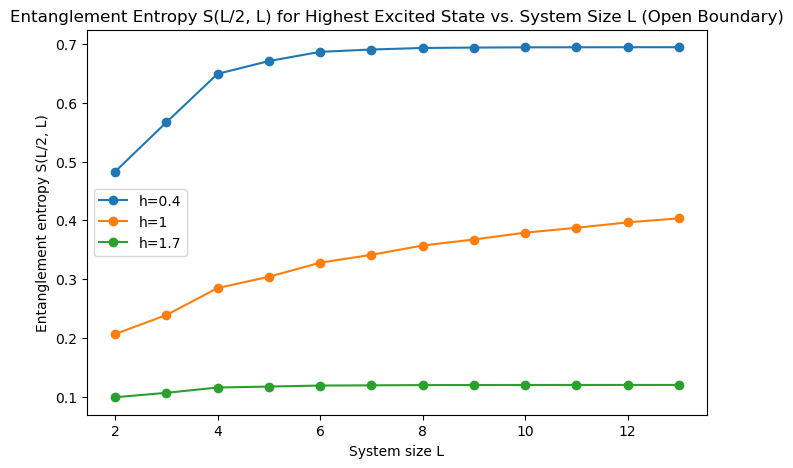

In [13]:
import matplotlib.pyplot as plt
from tqdm import tqdm

L_values = range(2, 14)
h_values = [0.4, 1, 1.7]

# Prepare the plot
plt.figure(figsize=(8, 5))

# Loop over h values
for h in h_values:
    entropy_values = []

    # Calculate entanglement entropy for L/2 for each L
    for L in tqdm(L_values, desc=f"Calculating Entropy for h={h}"):
        periodic = False
        H = ising_sparse(L, h, 1, periodic)
        
        # Compute entanglement entropy for the middle of the chain, L/2
        l = L // 2  # Use floor division to handle odd L
        
        # Pass 'highest=True' to compute for the highest excited state
        entropy = entanglement_entropy(H, L, l, highest=True)
        
        entropy_values.append(entropy)

    # Plot S(L/2, L) as a function of L for the current h
    plt.plot(list(L_values), entropy_values, marker='o', label=f'h={h}')

# Finalize the plot
plt.xlabel('System size L')
plt.ylabel('Entanglement entropy S(L/2, L)')
plt.title('Entanglement Entropy S(L/2, L) for Highest Excited State vs. System Size L (Open Boundary)')
plt.legend()
plt.show()


Plot of S(L/2,L) for highest energy state with open boundary conditions

Calculating Entropy for h=1.7: 100%|████████████| 12/12 [00:00<00:00, 19.15it/s]


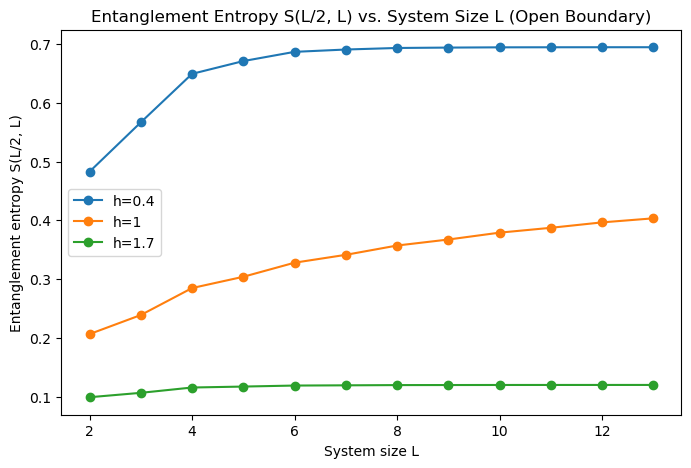

In [16]:
import matplotlib.pyplot as plt
from tqdm import tqdm


L_values = range(2, 14)
h_values = [0.4, 1, 1.7]

# Prepare the plot
plt.figure(figsize=(8, 5))

# Loop over h values
for h in h_values:
    entropy_values = []

    # Calculate entanglement entropy for L/2 for each L
    for L in tqdm(L_values, desc=f"Calculating Entropy for h={h}"):
        periodic = False
        H = ising_sparse(L, h, 1, periodic)
        
        # Compute entanglement entropy for the middle of the chain, L/2
        l = L // 2  # Use floor division to handle odd L
        entropy = entanglement_entropy(H, L, l)
        entropy_values.append(entropy)

    # Plot S(L/2, L) as a function of L for the current h
    plt.plot(list(L_values), entropy_values, marker='o', label=f'h={h}')

# Finalize the plot
plt.xlabel('System size L')
plt.ylabel('Entanglement entropy S(L/2, L)')
plt.title('Entanglement Entropy S(L/2, L) vs. System Size L (Open Boundary)')
plt.legend()
plt.show()

5.5 MPS Approximation

In [ ]:
import numpy as np
from scipy.linalg import svd

def compute_mps(wavefunction, max_bond_dim):
    L = int(np.log2(wavefunction.shape[0]))  # Calculate the number of spins/qubits

    mps_tensors = []
    current_tensor = wavefunction
    sz = current_tensor.shape[0] * 2
    matrix = current_tensor.reshape(2, 2**(L-1))# Reshape the tensor for SVD
    for i in range(L - 1):
          # Size of the "row" dimension in the reshaping for SVD
        

        U, s, Vh = svd(matrix, full_matrices=False)  # Perform SVD

        min_dim = min(len(s), max_bond_dim)  # Determine the bond dimension to keep
        U = U[:, :min_dim]
        s = s[:min_dim]
        Vh = Vh[:min_dim, :]
        
        if i == 0:
            
            mps_tensors.append(U)
            
        else:

            mps_tensors.append(U.reshape((-1, 2, min_dim)))  # Reshape U and store as part of the MPS

        if i<L-2:
            matrix=(np.diag(s)@Vh).reshape(2 * min_dim,-1)
        else:
            mps_tensors.append(np.diag(s)@Vh)
            

    return mps_tensors

# Example usage:
# Assume a hypothetical wavefunction for a system of 3 qubits (8 complex amplitudes, normalized).
H=ising_sparse(6,1,1, False)
eigvals, eigvecs = scipy.sparse.linalg.eigsh(H, k=1, which='SA')
wavefunction = eigvecs

mps_approx = compute_mps(wavefunction, max_bond_dim=4)
for i, tensor in enumerate(mps_approx):
    print(f"Tensor {i} shape: {tensor.shape}")


In [ ]:
def reconstruct_wavefunction(mps_tensors):
    # Start with the first tensor, assuming it is correctly shaped as (d, chi)
    wavefunction = mps_tensors[0].reshape(-1)  # Flatten the first tensor to start the contractions

    # Contract each subsequent tensor with the current wavefunction
    for tensor in mps_tensors[1:]:
        # Current wavefunction is reshaped to align with the 'left' bond dimension of the next tensor
        wavefunction = wavefunction.reshape(-1, tensor.shape[0])
        
        # The next tensor must be reshaped to align the 'right' bond dimension for matrix multiplication
        tensor = tensor.reshape(tensor.shape[0], -1)
        
        # Matrix multiplication to merge tensors, contracting over the shared bond dimension
        wavefunction = np.dot(wavefunction, tensor)

    # After finishing all contractions, the wavefunction is a flat array; normalize it
    return wavefunction / np.linalg.norm(wavefunction)

# Example use case:
H=ising_sparse(6,1,1, False)
eigvals, eigvecs = scipy.sparse.linalg.eigsh(H, k=1, which='SA')
wavefunction = eigvecs
wavefunction /= np.linalg.norm(wavefunction)  # Normalize the initial wavefunction

# Assuming mps_approx is generated from the MPS computation code provided earlier
try:
    original_wavefunction = reconstruct_wavefunction(mps_approx)
    print("Reconstructed Wavefunction:\n", original_wavefunction)
except Exception as e:
    print("Error during reconstruction:", str(e))
